In [2]:
from galvani import BioLogic
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec

In [3]:
def rrcrc_model(omega, R0, R1, C1, R2, C2):
    Z_R1C1 = R1 / (1 + 1j * omega * R1 * C1)
    Z_R2C2 = R2 / (1 + 1j * omega * R2 * C2)
    Z = R0 + Z_R1C1 + Z_R2C2
    return np.concatenate((np.real(Z), np.imag(Z)))

In [4]:
def rrcrc_cpe_model(omega, R0, R1, fs1, n1, R2, fs2, n2):
    Z_R1CPE1 = R1 / (1 + (1j * omega / fs1)**n1)
    Z_R2CPE2 = R2 / (1 + (1j * omega / fs2)**n2)
    Z = R0 + Z_R1CPE1 + Z_R2CPE2
    return np.concatenate((np.real(Z), np.imag(Z)))

# Import Data

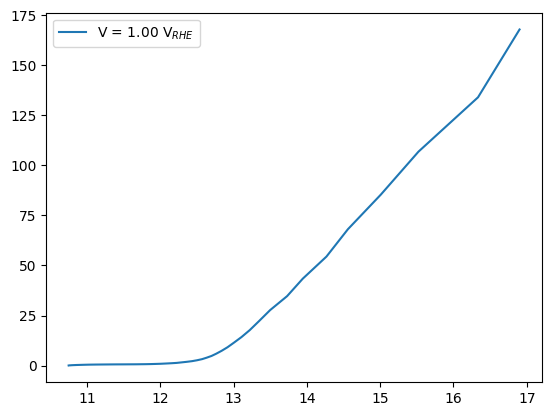

In [32]:
mpr_file = BioLogic.MPRfile('MPR files/1_00V_10cyc.mpr')
df = pd.DataFrame(mpr_file.data)

freq_min = 4
freq_max = 1e6
filtered_df = df[(df['freq/Hz'] >= freq_min) & (df['freq/Hz'] <= freq_max)]

Ewe = filtered_df["<Ewe>/V"].mean()

frequencies = filtered_df['freq/Hz'].values
real = filtered_df['Re(Z)/Ohm'].values
imaginary = -filtered_df['-Im(Z)/Ohm'].values

Z = np.concatenate((real, imaginary))

omega = 2 * np.pi * frequencies

plt.plot(real, -imaginary, label = f"V = {Ewe:.2f} V$_{{RHE}}$")
plt.legend()

# Simple R-RC-RC circuit

Optimal parameters: R0=11.291497531099232, R1=1.9311794581020274, C1=0.00011179487852162504, R2=6373.962332112819, C2=0.00018749426134191053
R^2 (Real part): 0.9292148575186729
R^2 (Imaginary part): 0.999835349881323


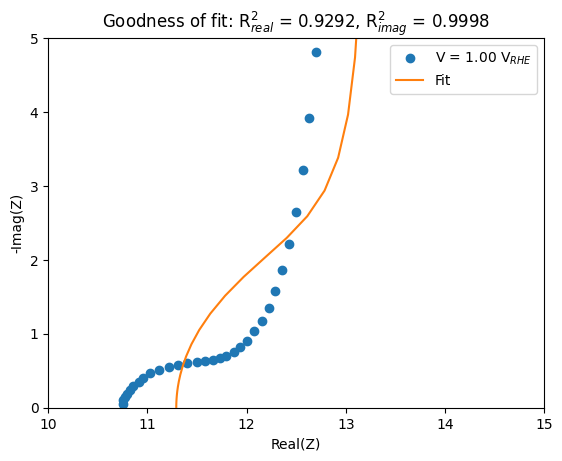

In [33]:
Rs_guess = 11.

R_guess = 1.5
n_guess = 1.
Q_guess = 3.2e-5

R2_guess = 6e4
n2_guess = 1.
Q2_guess = 1.2e-4

initial_guess = [Rs_guess, R_guess, Q_guess, R2_guess, Q2_guess]
bounds = (
    [5, 1, 1e-7, 1, 1e-7],  # Lower bounds
    [15, 5, 1e-3, 1e6, 1e-3]  # Upper bounds
)

popt, pcov = curve_fit(rrcrc_model, omega, Z, p0=initial_guess, bounds=bounds)

R0_opt, R1_opt, C1_opt, R2_opt, C2_opt = popt
print(f'Optimal parameters: R0={R0_opt}, R1={R1_opt}, C1={C1_opt}, R2={R2_opt}, C2={C2_opt}')

Z_fit = rrcrc_model(omega, *popt)
real_fit = Z_fit[:len(frequencies)]
imaginary_fit = Z_fit[len(frequencies):]

def calculate_r_squared(observed, predicted):
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (ss_res / ss_tot)

r_squared_real = calculate_r_squared(real, real_fit)
r_squared_imaginary = calculate_r_squared(imaginary, imaginary_fit)
print(f'R^2 (Real part): {r_squared_real}')
print(f'R^2 (Imaginary part): {r_squared_imaginary}')

plt.plot(real, -imaginary, 'o', label=f"V = {Ewe:.2f} V$_{{RHE}}$")
plt.plot(real_fit, -imaginary_fit, '-', label='Fit')
plt.xlabel('Real(Z)')
plt.ylabel('-Imag(Z)')
plt.xlim([10,15])
plt.ylim([0,5])
plt.title(f'Goodness of fit: R$^2_{{real}}$ = {r_squared_real:.4f}, R$^2_{{imag}}$ = {r_squared_imaginary:.4f}')
plt.legend()


# Randle R-RC-RC circuit (CPE - constant phase element)

Optimal parameters: R0=10.489153743341259, R1=2.4691068157811853, fs1=25945.466681405374, n1=0.5000000000000001, R2=465574.26711669797, fs2=0.0100000000000103, n2=0.9839761613948123
R^2 (Real part): 0.9984587458893657
R^2 (Imaginary part): 0.9999932153746158


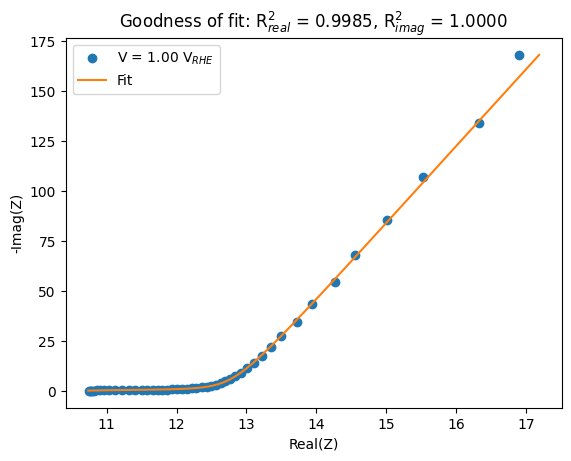

In [34]:
Rs_guess = 11.

R_guess = 1.5
n_guess = 1.
fs_guess = 10**1.3

R2_guess = 6e4
n2_guess = 1.
fs2_guess = 10**0.5

initial_guess = [Rs_guess, R_guess, fs_guess, n_guess, R2_guess, fs2_guess, n2_guess]

bounds = (
    [5, 1, 1e-2, 0.5, 1, 1e-2, 0.5],  # Lower bounds
    [15, 5, 1e7, 1.5, 1e6, 1e7, 1.5]  # Upper bounds

)

popt, pcov = curve_fit(rrcrc_cpe_model, omega, Z, p0=initial_guess, bounds=bounds)

R0_opt, R1_opt, fs1_opt, n1_opt, R2_opt, fs2_opt, n2_opt = popt
print(f'Optimal parameters: R0={R0_opt}, R1={R1_opt}, fs1={fs1_opt}, n1={n1_opt}, R2={R2_opt}, fs2={fs2_opt}, n2={n2_opt}')

Z_fit = rrcrc_cpe_model(omega, *popt)
real_fit = Z_fit[:len(frequencies)]
imaginary_fit = Z_fit[len(frequencies):]

def calculate_r_squared(observed, predicted):
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (ss_res / ss_tot)

r_squared_real = calculate_r_squared(real, real_fit)
r_squared_imaginary = calculate_r_squared(imaginary, imaginary_fit)
print(f'R^2 (Real part): {r_squared_real}')
print(f'R^2 (Imaginary part): {r_squared_imaginary}')

plt.plot(real, -imaginary, 'o', label=f"V = {Ewe:.2f} V$_{{RHE}}$")
plt.plot(real_fit, -imaginary_fit, '-', label='Fit')
plt.xlabel('Real(Z)')
plt.ylabel('-Imag(Z)')
#plt.xlim([10,15])
#plt.ylim([0,5])
plt.title(f'Goodness of fit: R$^2_{{real}}$ = {r_squared_real:.4f}, R$^2_{{imag}}$ = {r_squared_imaginary:.4f}')
plt.legend()


# 10 cycles with R-RCPE-RCPE circuit

## Find all files

In [7]:
import os

def find_files(root_folder, extension):
    file_list = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(extension):
                file_list.append(os.path.join(root, file))
    return file_list

# Example usage:
root_folder = "10 cycles imped"
extension = ".mpr"
mpr_files = find_files(root_folder, extension)
mpr_files.sort(reverse=True)

## Fit high frequency section

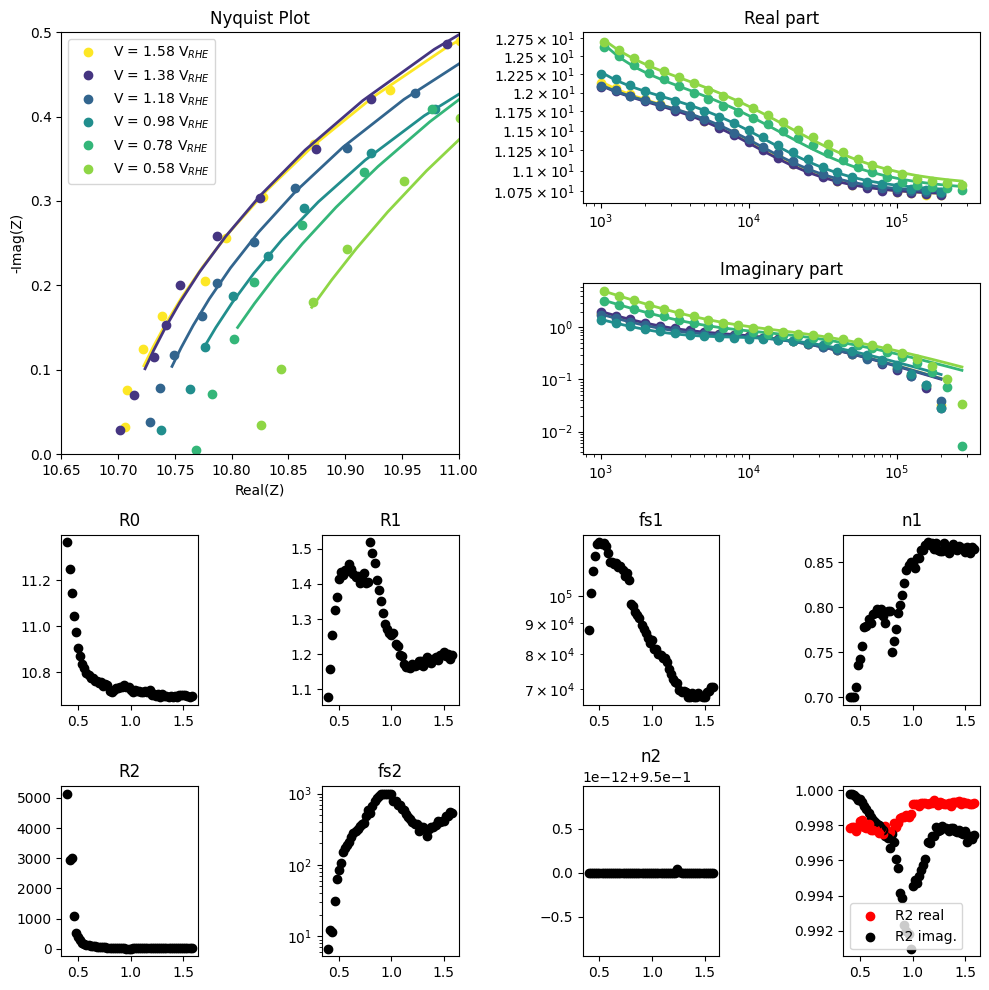

In [8]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(4, 4)

ax1 = fig.add_subplot(gs[:2, :2])
ax1.set_title('Nyquist Plot')

ax2 = fig.add_subplot(gs[0, 2:])
ax2.set_title('Real part')

ax3 = fig.add_subplot(gs[1, 2:])
ax3.set_title('Imaginary part')

axes = []
for i in range(4):
    for j in range(2, 4):
        ax = fig.add_subplot(gs[j, i])
        axes.append(ax)

from matplotlib.cm import viridis
colors = viridis(np.linspace(0, 1, len(mpr_files)))

Rs_guess = 10.66

R_guess = 1.37
n_guess = 0.8
fs_guess = 5.7e4

R2_guess = 65.8
n2_guess = 0.97
fs2_guess = 128.9

initial_guess = [Rs_guess, R_guess, fs_guess, n_guess, R2_guess, fs2_guess, n2_guess]

bounds = (
    [9., 1., 10**1, 0.7, 1, 10**0.1, 0.95],  # Lower bounds
    [12., 4., 10**7, 1.25, 1e8, 10**3, 1.05]  # Upper bounds

)

popt = []

fitted_values_HF_10cyc = dict()


for (n_file,file_path) in enumerate(mpr_files):
    mpr_file = BioLogic.MPRfile(file_path)
    df = pd.DataFrame(mpr_file.data)

    freq_min = 1000
    freq_max = 1e6
    filtered_df = df[(df['freq/Hz'] >= freq_min) & (df['freq/Hz'] <= freq_max) & (df['-Im(Z)/Ohm'] > 0)]

    Ewe = filtered_df["<Ewe>/V"].mean()

    frequencies = filtered_df['freq/Hz'].values
    real = filtered_df['Re(Z)/Ohm'].values
    imaginary = -filtered_df['-Im(Z)/Ohm'].values

    Z = np.concatenate((real, imaginary))
    omega = 2 * np.pi * frequencies

    try:
        if len(popt)>0:
            popt, pcov = curve_fit(rrcrc_cpe_model, omega, Z, p0=popt, bounds=bounds)
        else:
            popt, pcov = curve_fit(rrcrc_cpe_model, omega, Z, p0=initial_guess, bounds=bounds)

        R0_opt, R1_opt, fs1_opt, n1_opt, R2_opt, fs2_opt, n2_opt = popt

        fitted_values_HF_10cyc[file_path] = (Ewe,popt)
        #print(f'Ewe={Ewe:.2f} V, Optimal parameters: R0={R0_opt}, R1={R1_opt}, fs1={fs1_opt}, n1={n1_opt}, R2={R2_opt}, fs2={fs2_opt}, n2={n2_opt}')

        Z_fit = rrcrc_cpe_model(omega, *popt)
        real_fit = Z_fit[:len(frequencies)]
        imaginary_fit = Z_fit[len(frequencies):]

        if n_file%10 == 0:
            ax1.plot(real, -imaginary, 'o', color=colors[n_file-1], label=f"V = {Ewe:.2f} V$_{{RHE}}$")
            ax1.plot(real_fit, -imaginary_fit, '-', lw = 2,  color=colors[n_file-1])
            ax1.set_xlabel('Real(Z)')
            ax1.set_ylabel('-Imag(Z)')

            ax2.plot(frequencies, real, 'o', color=colors[n_file-1])
            ax2.plot(frequencies, real_fit, '-', lw=2, color=colors[n_file-1])
            
            ax3.plot(frequencies, -imaginary, 'o',color=colors[n_file-1])
            ax3.plot(frequencies, -imaginary_fit, '-', lw=2, color=colors[n_file-1])

        axes[0].scatter(Ewe, R0_opt, c = "k")
        axes[2].scatter(Ewe, R1_opt, c = "k")
        axes[4].scatter(Ewe, fs1_opt, c = "k")
        axes[6].scatter(Ewe, n1_opt, c = "k")
        axes[1].scatter(Ewe, R2_opt, c = "k")
        axes[3].scatter(Ewe, fs2_opt, c = "k")
        axes[5].scatter(Ewe, n2_opt, c = "k")

        def calculate_r_squared(observed, predicted):
            ss_res = np.sum((observed - predicted) ** 2)
            ss_tot = np.sum((observed - np.mean(observed)) ** 2)
            return 1 - (ss_res / ss_tot)

        r_squared_real = calculate_r_squared(real, real_fit)
        r_squared_imaginary = calculate_r_squared(imaginary, imaginary_fit)

        if n_file == 0:
            axes[7].scatter(Ewe, r_squared_real, c = "r", label = "R2 real")
            axes[7].scatter(Ewe, r_squared_imaginary, c = "k", label = "R2 imag.")
        else:
            axes[7].scatter(Ewe, r_squared_real, c = "r")
            axes[7].scatter(Ewe, r_squared_imaginary, c = "k")

    except RuntimeError:
        print(f"Ewe={Ewe:.2f} V - No fit")

axes[0].set_title("R0")
axes[2].set_title("R1")
axes[4].set_title("fs1")
axes[4].set_yscale("log")
axes[6].set_title("n1")
axes[1].set_title("R2")
axes[3].set_title("fs2")
axes[3].set_yscale("log")
axes[5].set_title("n2")

axes[7].legend()
ax1.legend()
ax1.set_xlim([10.65,11])
ax1.set_ylim([0,0.5])

ax2.set_xscale("log")
ax2.set_yscale("log")
ax3.set_xscale("log")
ax3.set_yscale("log")

plt.tight_layout()

## Fit whole range with HF values for first element

1.5805103 [1.06939167e+01 1.19742553e+00 7.04551097e+04 8.64737040e-01
 1.88491470e+01 5.28217764e+02 9.50000000e-01]
1.5805103 [1.06601742e+01 1.36716917e+00 5.71160410e+04 7.96509317e-01
 6.58213506e+01 1.28907284e+02 9.69457612e-01]
1.5605386 [1.06903827e+01 1.18570260e+00 7.06310077e+04 8.67249361e-01
 1.80152824e+01 5.42680204e+02 9.50000000e-01]
1.5605386 [1.06795698e+01 1.24567946e+00 6.25351998e+04 8.54003175e-01
 1.15814248e+02 6.87198766e+01 9.63082642e-01]
1.5405238 [1.06951714e+01 1.20155737e+00 6.95811576e+04 8.60636477e-01
 1.96238291e+01 4.91115260e+02 9.50000000e-01]
1.5405238 [1.06998061e+01 1.18788415e+00 6.57304400e+04 8.86734093e-01
 2.31463017e+02 3.28677270e+01 9.57141657e-01]
1.5205666 [1.07004016e+01 1.19375480e+00 6.92016618e+04 8.66607515e-01
 2.05593213e+01 4.78754312e+02 9.50000000e-01]
1.5205666 [1.07121828e+01 1.15155882e+00 6.71442718e+04 9.09875098e-01
 5.13006276e+02 1.42398130e+01 9.50094068e-01]


/tmp/ipykernel_18319/944145506.py:66: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axes[0].errorbar(Ewe, popt_HF[0], yerr= [[popt_HF[0]*lim_R0], [popt_HF[0]*lim_R0]], fmt='o', ecolor='b', capsize=5, marker='o', markerfacecolor='b', markeredgecolor='b')
/tmp/ipykernel_18319/944145506.py:67: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axes[2].errorbar(Ewe, popt_HF[1], yerr= [[popt_HF[1]*lim_R1], [popt_HF[1]*lim_R1]], fmt='o', ecolor='b', capsize=5, marker='o', markerfacecolor='b', markeredgecolor='b')
/tmp/ipykernel_18319/944145506.py:68: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axes[4].errorbar(Ewe, popt_HF[2], yerr= [[popt_HF[2]*lim_fs1], 

1.500542 [1.07016764e+01 1.20491135e+00 6.79614725e+04 8.61826577e-01
 2.45562822e+01 4.08089842e+02 9.50000000e-01]
1.500542 [1.07212896e+01 1.12676278e+00 6.85070789e+04 9.23463624e-01
 1.30868140e+03 5.34711397e+00 9.43104679e-01]
1.4805504 [1.06989261e+01 1.19706316e+00 6.79405927e+04 8.65507793e-01
 2.49884600e+01 4.14711699e+02 9.50000000e-01]
1.4805504 [1.07282702e+01 1.05139604e+00 7.28899672e+04 9.63671283e-01
 3.49289135e+03 1.88877583e+00 9.36594671e-01]
1.4605337 [1.06998126e+01 1.19696755e+00 6.81333995e+04 8.66134217e-01
 2.66863783e+01 3.95613609e+02 9.50000000e-01]
1.4605337 [1.06711446e+01 1.27189587e+00 6.25355895e+04 8.16066289e-01
 5.31703431e+03 1.25892541e+00 9.40877926e-01]
1.4405863 [1.06894510e+01 1.18412405e+00 6.89811395e+04 8.68492304e-01
 2.60123204e+01 4.12344008e+02 9.50000000e-01]
1.4405863 [1.05882770e+01 1.43276837e+00 5.85855221e+04 7.00000001e-01
 5.58865533e+03 1.25892541e+00 9.46585370e-01]
1.4205669 [1.06975525e+01 1.19174599e+00 6.78143139e+04 8.

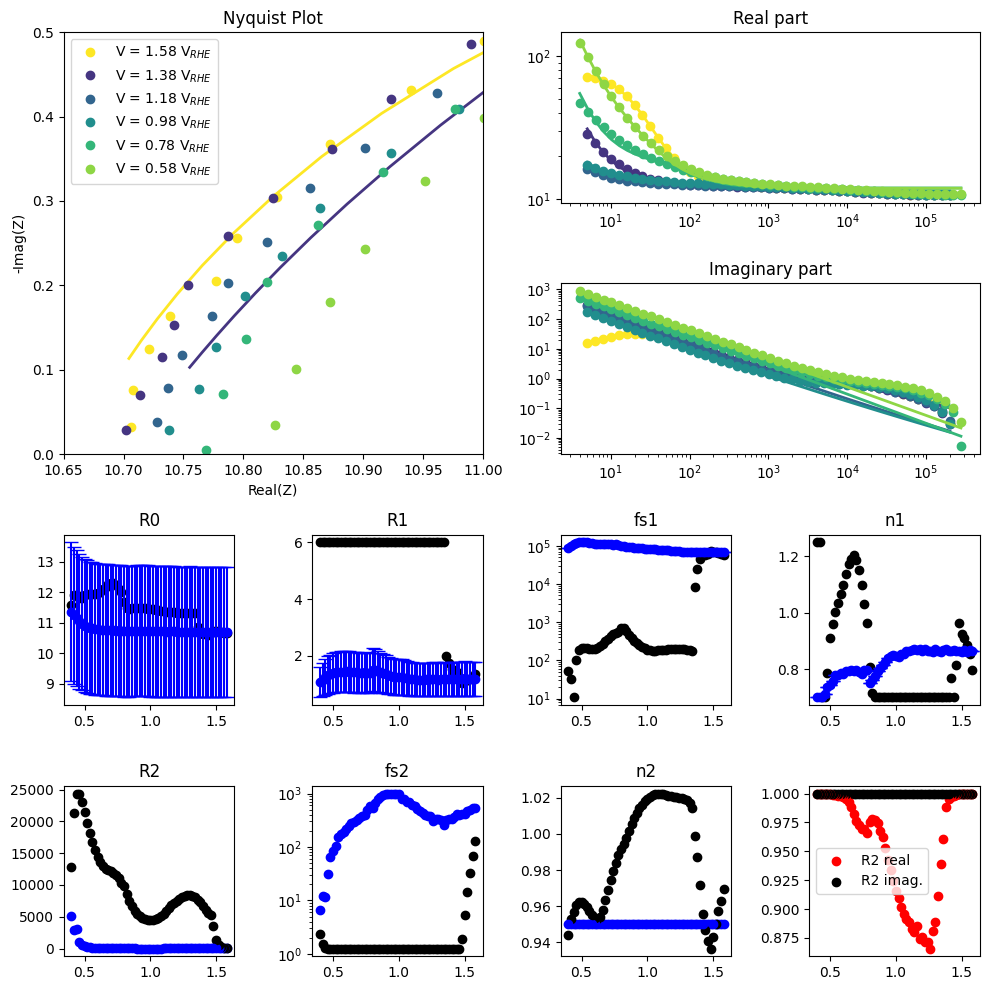

In [9]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(4, 4)

ax1 = fig.add_subplot(gs[:2, :2])
ax1.set_title('Nyquist Plot')

ax2 = fig.add_subplot(gs[0, 2:])
ax2.set_title('Real part')

ax3 = fig.add_subplot(gs[1, 2:])
ax3.set_title('Imaginary part')

axes = []
for i in range(4):
    for j in range(2, 4):
        ax = fig.add_subplot(gs[j, i])
        axes.append(ax)

from matplotlib.cm import viridis
colors = viridis(np.linspace(0, 1, len(mpr_files)))

# These values from the HR fit of 10 cyc 1.58 V
Rs_guess = 10.69

R_guess = 1.197
n_guess = 0.865
fs_guess = 7.045e4

# These values from first fit from Ben
R2_guess = 65.8
n2_guess = 0.97
fs2_guess = 128.9

initial_guess = [Rs_guess, R_guess, fs_guess, n_guess, R2_guess, fs2_guess, n2_guess]

popt = []

fitted_values_10cyc = dict()

for (n_file,file_path) in enumerate(mpr_files):
    mpr_file = BioLogic.MPRfile(file_path)
    df = pd.DataFrame(mpr_file.data)

    freq_min = 4
    freq_max = 1e6
    filtered_df = df[(df['freq/Hz'] >= freq_min) & (df['freq/Hz'] <= freq_max) & (df['-Im(Z)/Ohm'] > 0)]

    Ewe = filtered_df["<Ewe>/V"].mean()

    frequencies = filtered_df['freq/Hz'].values
    real = filtered_df['Re(Z)/Ohm'].values
    imaginary = -filtered_df['-Im(Z)/Ohm'].values

    Z = np.concatenate((real, imaginary))
    omega = 2 * np.pi * frequencies

    (Ewe_HF, popt_HF) = fitted_values_HF_10cyc[file_path]

    print (Ewe,popt_HF)

    lim_R0 = 0.2
    lim_R1 = 0.5
    lim_fs1 = 0.
    lim_n1 = 0.

    axes[0].errorbar(Ewe, popt_HF[0], yerr= [[popt_HF[0]*lim_R0], [popt_HF[0]*lim_R0]], fmt='o', ecolor='b', capsize=5, marker='o', markerfacecolor='b', markeredgecolor='b')
    axes[2].errorbar(Ewe, popt_HF[1], yerr= [[popt_HF[1]*lim_R1], [popt_HF[1]*lim_R1]], fmt='o', ecolor='b', capsize=5, marker='o', markerfacecolor='b', markeredgecolor='b')
    axes[4].errorbar(Ewe, popt_HF[2], yerr= [[popt_HF[2]*lim_fs1], [popt_HF[2]*lim_fs1]], fmt='o', ecolor='b', capsize=5, marker='o', markerfacecolor='b', markeredgecolor='b')
    axes[6].errorbar(Ewe, popt_HF[3], yerr= [[popt_HF[3]*lim_n1], [popt_HF[3]*lim_n1]], fmt='o', ecolor='b', capsize=5, marker='o', markerfacecolor='b', markeredgecolor='b')

    axes[1].scatter(Ewe, popt_HF[4], c = "b")
    axes[3].scatter(Ewe, popt_HF[5], c = "b")
    axes[5].scatter(Ewe, popt_HF[6], c = "b")

    ##################################### there is some problem here ###################################################
    #bounds = (
    #[(1-lim_R0)*popt_HF[0], (1-lim_R1)*popt_HF[1], 0.5*popt_HF[2], 0.75*popt_HF[3], 1, 10**0.1, 0.95],  # Lower bounds
    #[(1+lim_R0)*popt_HF[0], (1+lim_R1)*popt_HF[1], 1.5*popt_HF[2], 1.25*popt_HF[3], 1e8, 10**3, 1.05]  # Upper bounds
    #)

    #bounds = (
    #[(1-lim_R0)*popt_HF[0], (1-lim_R1)*popt_HF[1], (1-lim_fs1)*popt_HF[2], (1-lim_n1)*popt_HF[3], 1., 10**0.1, 0.9],  # Lower bounds
    #[(1+lim_R0)*popt_HF[0], (1+lim_R1)*popt_HF[1], (1+lim_fs1)*popt_HF[2], (1+lim_n1)*popt_HF[3], 1e8, 10**3, 1.05]  # Upper bounds
    #)

    #bounds = (
    #[(1-lim_R0)*popt_HF[0],1., 1e-1, 0.7, 1, 1e-1, 0.95],  # Lower bounds
    #[(1+lim_R0)*popt_HF[0], 20., 1e7, 1.25, 1e8, 1e3, 1.05]  # Upper bounds
    #)

    bounds = (
    [(1-lim_R0)*popt_HF[0], 1., 10**1, 0.7, 1, 10**0.1, 0.9],  # Lower bounds
    [(1+lim_R0)*popt_HF[0], 6., 10**7, 1.25, 1e8, 10**3, 1.05]  # Upper bounds
    )

    #######################################################################################

    try:
        if len(popt)>0:
            popt, pcov = curve_fit(rrcrc_cpe_model, omega, Z, p0=popt, bounds=bounds)
        else:
            popt, pcov = curve_fit(rrcrc_cpe_model, omega, Z, p0=initial_guess, bounds=bounds)

        R0_opt, R1_opt, fs1_opt, n1_opt, R2_opt, fs2_opt, n2_opt = popt

        fitted_values_10cyc[file_path] = (Ewe,popt)
        print (Ewe,popt)
        

        Z_fit = rrcrc_cpe_model(omega, *popt)
        real_fit = Z_fit[:len(frequencies)]
        imaginary_fit = Z_fit[len(frequencies):]

        if n_file%10 == 0:
            ax1.plot(real, -imaginary, 'o', color=colors[n_file-1], label=f"V = {Ewe:.2f} V$_{{RHE}}$")
            ax1.plot(real_fit, -imaginary_fit, '-', lw = 2,  color=colors[n_file-1])
            ax1.set_xlabel('Real(Z)')
            ax1.set_ylabel('-Imag(Z)')

            ax2.plot(frequencies, real, 'o', color=colors[n_file-1])
            ax2.plot(frequencies, real_fit, '-', lw=2, color=colors[n_file-1])
            
            ax3.plot(frequencies, -imaginary, 'o',color=colors[n_file-1])
            ax3.plot(frequencies, -imaginary_fit, '-', lw=2, color=colors[n_file-1])

        axes[0].scatter(Ewe, R0_opt, c = "k")
        axes[2].scatter(Ewe, R1_opt, c = "k")
        axes[4].scatter(Ewe, fs1_opt, c = "k")
        axes[6].scatter(Ewe, n1_opt, c = "k")
        axes[1].scatter(Ewe, R2_opt, c = "k")
        axes[3].scatter(Ewe, fs2_opt, c = "k")
        axes[5].scatter(Ewe, n2_opt, c = "k")


        def calculate_r_squared(observed, predicted):
            ss_res = np.sum((observed - predicted) ** 2)
            ss_tot = np.sum((observed - np.mean(observed)) ** 2)
            return 1 - (ss_res / ss_tot)

        r_squared_real = calculate_r_squared(real, real_fit)
        r_squared_imaginary = calculate_r_squared(imaginary, imaginary_fit)

        if n_file == 0:
            axes[7].scatter(Ewe, r_squared_real, c = "r", label = "R2 real")
            axes[7].scatter(Ewe, r_squared_imaginary, c = "k", label = "R2 imag.")
        else:
            axes[7].scatter(Ewe, r_squared_real, c = "r")
            axes[7].scatter(Ewe, r_squared_imaginary, c = "k")

    except RuntimeError:
        print(f"Ewe={Ewe:.2f} V - No fit")
    except ValueError:
        print(f"Ewe={Ewe:.2f} V - No fit")

axes[0].set_title("R0")
axes[2].set_title("R1")
axes[4].set_title("fs1")
axes[4].set_yscale("log")
axes[6].set_title("n1")
axes[1].set_title("R2")
axes[3].set_title("fs2")
axes[3].set_yscale("log")
axes[5].set_title("n2")

axes[7].legend()
ax1.legend()
ax1.set_xlim([10.65,11])
ax1.set_ylim([0,0.5])

ax2.set_xscale("log")
ax2.set_yscale("log")
ax3.set_xscale("log")
ax3.set_yscale("log")

plt.tight_layout()

# 50 cycles with R-RCPE-RCPE circuit

## Find all files

In [10]:
import os

def find_files(root_folder, extension):
    file_list = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(extension):
                file_list.append(os.path.join(root, file))
    return file_list

# Example usage:
root_folder = "50 cycles imped"
extension = ".mpr"
mpr_files = find_files(root_folder, extension)
mpr_files.sort(reverse=True)

## Fit high frequency section

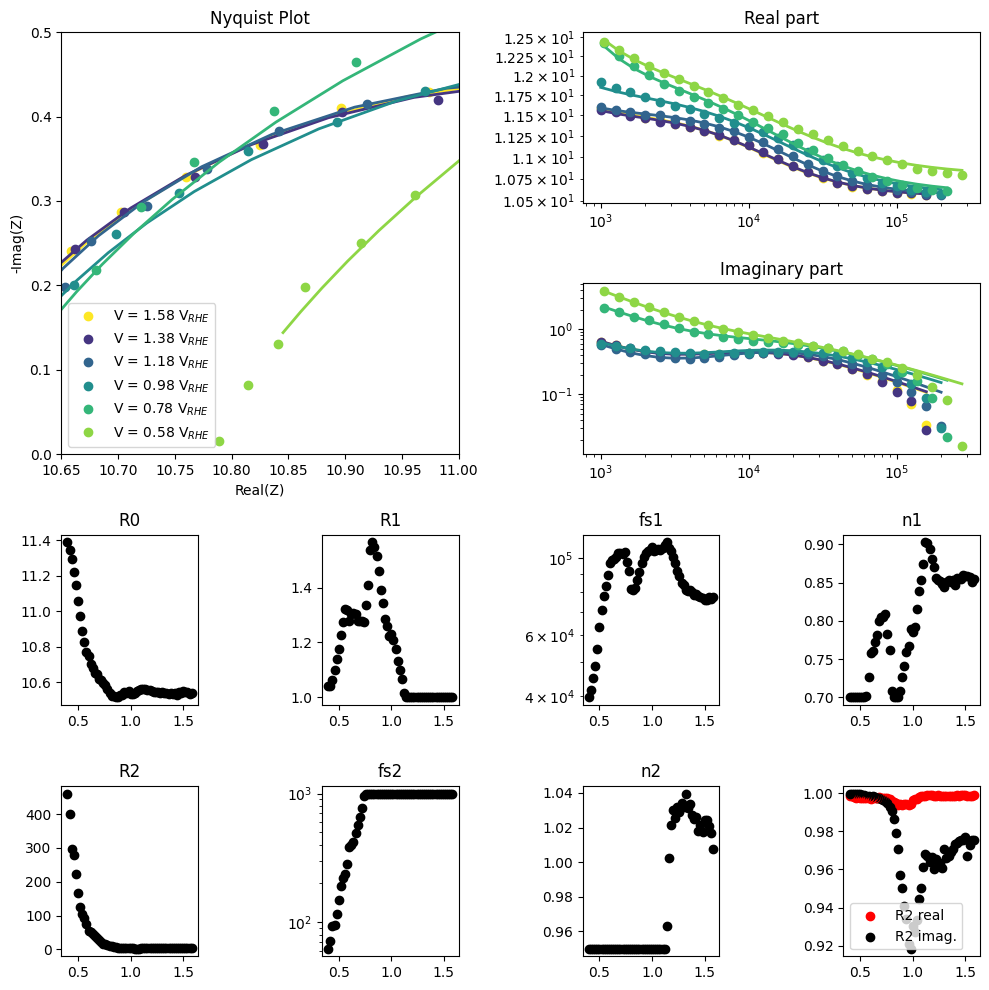

In [11]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(4, 4)

ax1 = fig.add_subplot(gs[:2, :2])
ax1.set_title('Nyquist Plot')

ax2 = fig.add_subplot(gs[0, 2:])
ax2.set_title('Real part')

ax3 = fig.add_subplot(gs[1, 2:])
ax3.set_title('Imaginary part')

axes = []
for i in range(4):
    for j in range(2, 4):
        ax = fig.add_subplot(gs[j, i])
        axes.append(ax)

from matplotlib.cm import viridis
colors = viridis(np.linspace(0, 1, len(mpr_files)))

Rs_guess = 10.66

R_guess = 1.37
n_guess = 0.8
fs_guess = 5.7e4

R2_guess = 65.8
n2_guess = 0.97
fs2_guess = 128.9

initial_guess = [Rs_guess, R_guess, fs_guess, n_guess, R2_guess, fs2_guess, n2_guess]

bounds = (
    [9., 1., 10**1, 0.7, 1, 10**0.1, 0.95],  # Lower bounds
    [12., 4., 10**7, 1.25, 1e8, 10**3, 1.05]  # Upper bounds

)

popt = []

fitted_values_HF_50cyc = dict()


for (n_file,file_path) in enumerate(mpr_files):
    mpr_file = BioLogic.MPRfile(file_path)
    df = pd.DataFrame(mpr_file.data)

    freq_min = 1000
    freq_max = 1e6
    filtered_df = df[(df['freq/Hz'] >= freq_min) & (df['freq/Hz'] <= freq_max) & (df['-Im(Z)/Ohm'] > 0)]

    Ewe = filtered_df["<Ewe>/V"].mean()

    frequencies = filtered_df['freq/Hz'].values
    real = filtered_df['Re(Z)/Ohm'].values
    imaginary = -filtered_df['-Im(Z)/Ohm'].values

    Z = np.concatenate((real, imaginary))
    omega = 2 * np.pi * frequencies

    try:
        if len(popt)>0:
            popt, pcov = curve_fit(rrcrc_cpe_model, omega, Z, p0=popt, bounds=bounds)
        else:
            popt, pcov = curve_fit(rrcrc_cpe_model, omega, Z, p0=initial_guess, bounds=bounds)

        R0_opt, R1_opt, fs1_opt, n1_opt, R2_opt, fs2_opt, n2_opt = popt

        fitted_values_HF_50cyc[file_path] = (Ewe,popt)
        #print(f'Ewe={Ewe:.2f} V, Optimal parameters: R0={R0_opt}, R1={R1_opt}, fs1={fs1_opt}, n1={n1_opt}, R2={R2_opt}, fs2={fs2_opt}, n2={n2_opt}')

        Z_fit = rrcrc_cpe_model(omega, *popt)
        real_fit = Z_fit[:len(frequencies)]
        imaginary_fit = Z_fit[len(frequencies):]

        if n_file%10 == 0:
            ax1.plot(real, -imaginary, 'o', color=colors[n_file-1], label=f"V = {Ewe:.2f} V$_{{RHE}}$")
            ax1.plot(real_fit, -imaginary_fit, '-', lw = 2,  color=colors[n_file-1])
            ax1.set_xlabel('Real(Z)')
            ax1.set_ylabel('-Imag(Z)')

            ax2.plot(frequencies, real, 'o', color=colors[n_file-1])
            ax2.plot(frequencies, real_fit, '-', lw=2, color=colors[n_file-1])
            
            ax3.plot(frequencies, -imaginary, 'o',color=colors[n_file-1])
            ax3.plot(frequencies, -imaginary_fit, '-', lw=2, color=colors[n_file-1])

        axes[0].scatter(Ewe, R0_opt, c = "k")
        axes[2].scatter(Ewe, R1_opt, c = "k")
        axes[4].scatter(Ewe, fs1_opt, c = "k")
        axes[6].scatter(Ewe, n1_opt, c = "k")
        axes[1].scatter(Ewe, R2_opt, c = "k")
        axes[3].scatter(Ewe, fs2_opt, c = "k")
        axes[5].scatter(Ewe, n2_opt, c = "k")

        def calculate_r_squared(observed, predicted):
            ss_res = np.sum((observed - predicted) ** 2)
            ss_tot = np.sum((observed - np.mean(observed)) ** 2)
            return 1 - (ss_res / ss_tot)

        r_squared_real = calculate_r_squared(real, real_fit)
        r_squared_imaginary = calculate_r_squared(imaginary, imaginary_fit)

        if n_file == 0:
            axes[7].scatter(Ewe, r_squared_real, c = "r", label = "R2 real")
            axes[7].scatter(Ewe, r_squared_imaginary, c = "k", label = "R2 imag.")
        else:
            axes[7].scatter(Ewe, r_squared_real, c = "r")
            axes[7].scatter(Ewe, r_squared_imaginary, c = "k")

    except RuntimeError:
        print(f"Ewe={Ewe:.2f} V - No fit")

axes[0].set_title("R0")
axes[2].set_title("R1")
axes[4].set_title("fs1")
axes[4].set_yscale("log")
axes[6].set_title("n1")
axes[1].set_title("R2")
axes[3].set_title("fs2")
axes[3].set_yscale("log")
axes[5].set_title("n2")

axes[7].legend()
ax1.legend()
ax1.set_xlim([10.65,11])
ax1.set_ylim([0,0.5])

ax2.set_xscale("log")
ax2.set_yscale("log")
ax3.set_xscale("log")
ax3.set_yscale("log")

plt.tight_layout()

## Fit whole range with HF values for first element

1.5805185 [1.05423038e+01 1.00000000e+00 7.74777897e+04 8.55184101e-01
 3.50772603e+00 1.00000000e+03 1.00754368e+00]
1.5805185 [1.05048458e+01 1.29156509e+00 4.63326847e+04 7.00000000e-01
 3.22265720e+01 5.81515982e+01 9.49514670e-01]
1.5605375 [1.05368035e+01 1.00000000e+00 7.64243605e+04 8.51016513e-01
 3.43325412e+00 1.00000000e+03 1.01663776e+00]
1.5605375 [1.05053251e+01 1.28673915e+00 4.44565034e+04 7.00000000e-01
 5.51303378e+01 3.11686059e+01 9.46852347e-01]
1.540527 [1.05439704e+01 1.00000000e+00 7.74950334e+04 8.57349309e-01
 3.37823344e+00 1.00000000e+03 1.02091370e+00]
1.540527 [1.05081583e+01 1.28263542e+00 4.62448260e+04 7.00000000e-01
 1.09727502e+02 1.46103945e+01 9.41695118e-01]
1.5205723 [1.05451566e+01 1.00000000e+00 7.59083135e+04 8.59138409e-01
 3.42613120e+00 1.00000000e+03 1.02428534e+00]
1.5205723 [1.05103834e+01 1.27822169e+00 4.53787484e+04 7.00000000e-01
 2.60774691e+02 5.84743191e+00 9.37393619e-01]
1.5005492 [1.05494315e+01 1.00044043e+00 7.59083678e+04 8.

/tmp/ipykernel_18319/3483478972.py:66: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axes[0].errorbar(Ewe, popt_HF[0], yerr= [[popt_HF[0]*lim_R0], [popt_HF[0]*lim_R0]], fmt='o', ecolor='b', capsize=5, marker='o', markerfacecolor='b', markeredgecolor='b')
/tmp/ipykernel_18319/3483478972.py:67: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axes[2].errorbar(Ewe, popt_HF[1], yerr= [[popt_HF[1]*lim_R1], [popt_HF[1]*lim_R1]], fmt='o', ecolor='b', capsize=5, marker='o', markerfacecolor='b', markeredgecolor='b')
/tmp/ipykernel_18319/3483478972.py:68: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axes[4].errorbar(Ewe, popt_HF[2], yerr= [[popt_HF[2]*lim_fs1

1.4805489 [1.05391698e+01 1.00000000e+00 7.69002661e+04 8.59474688e-01
 3.67395330e+00 1.00000000e+03 1.01743654e+00]
1.4805489 [1.05369663e+01 1.33891417e+00 3.46650773e+04 7.00000000e-01
 1.19693402e+03 1.25892541e+00 9.41392417e-01]
1.460539 [1.05454800e+01 1.00000000e+00 7.71452673e+04 8.55008930e-01
 3.73991595e+00 1.00000000e+03 1.02171934e+00]
1.460539 [1.05611931e+01 1.34994862e+00 3.08806544e+04 7.00000000e-01
 1.24881459e+03 1.25892541e+00 9.45351527e-01]
1.4405929 [1.05301557e+01 1.00000000e+00 7.79943417e+04 8.55243759e-01
 3.74351921e+00 1.00000000e+03 1.01818743e+00]
1.4405929 [1.05335670e+01 1.33623761e+00 3.43369535e+04 7.00000000e-01
 1.29518512e+03 1.25892541e+00 9.48257653e-01]
1.4205707 [1.05392424e+01 1.00000000e+00 7.86425562e+04 8.56459674e-01
 3.71804258e+00 1.00000000e+03 1.02630346e+00]
1.4205707 [1.05343285e+01 1.32693334e+00 3.70062321e+04 7.00000000e-01
 1.37956988e+03 1.25892541e+00 9.56676773e-01]
1.4005796 [1.05343625e+01 1.00000000e+00 7.81921182e+04 8.

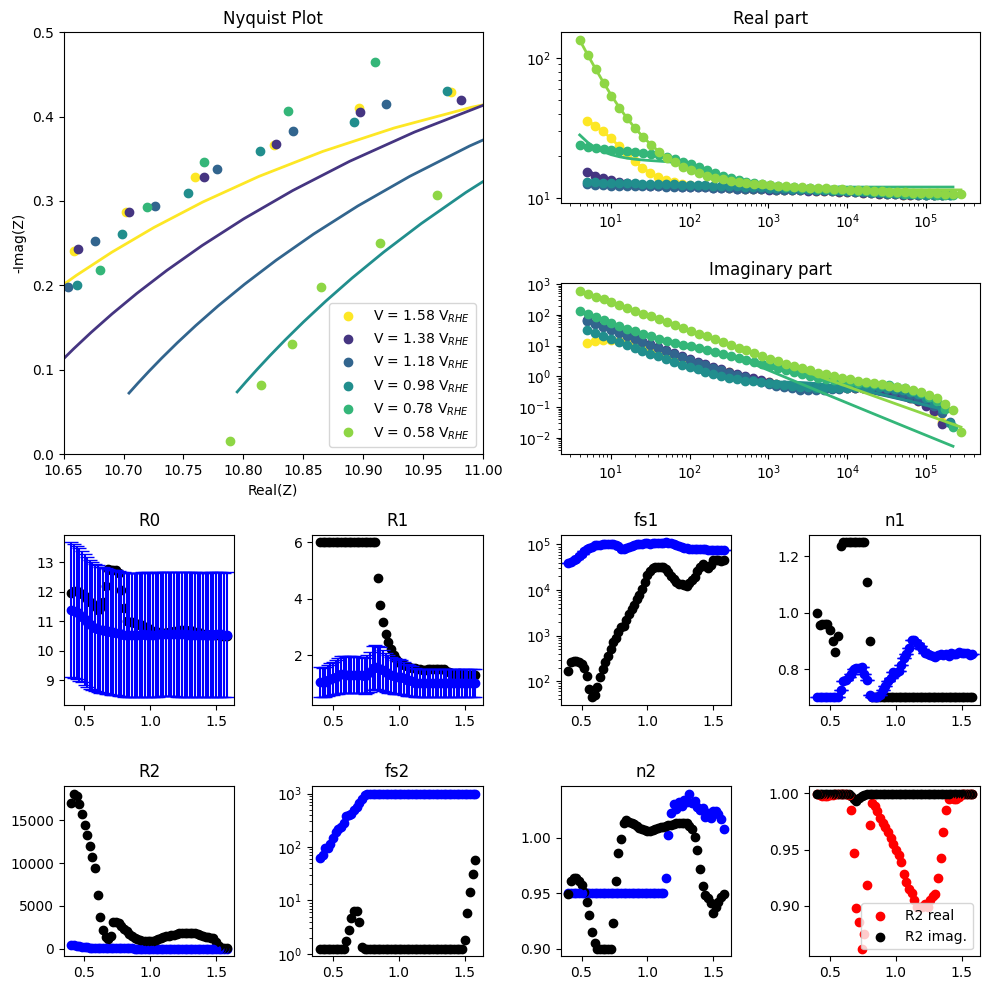

In [12]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(4, 4)

ax1 = fig.add_subplot(gs[:2, :2])
ax1.set_title('Nyquist Plot')

ax2 = fig.add_subplot(gs[0, 2:])
ax2.set_title('Real part')

ax3 = fig.add_subplot(gs[1, 2:])
ax3.set_title('Imaginary part')

axes = []
for i in range(4):
    for j in range(2, 4):
        ax = fig.add_subplot(gs[j, i])
        axes.append(ax)

from matplotlib.cm import viridis
colors = viridis(np.linspace(0, 1, len(mpr_files)))

# These values from the HR fit of 10 cyc 1.58 V
Rs_guess = 10.69

R_guess = 1.197
n_guess = 0.865
fs_guess = 7.045e4

# These values from first fit from Ben
R2_guess = 65.8
n2_guess = 0.97
fs2_guess = 128.9

initial_guess = [Rs_guess, R_guess, fs_guess, n_guess, R2_guess, fs2_guess, n2_guess]

popt = []

fitted_values_50cyc = dict()

for (n_file,file_path) in enumerate(mpr_files):
    mpr_file = BioLogic.MPRfile(file_path)
    df = pd.DataFrame(mpr_file.data)

    freq_min = 4
    freq_max = 1e6
    filtered_df = df[(df['freq/Hz'] >= freq_min) & (df['freq/Hz'] <= freq_max) & (df['-Im(Z)/Ohm'] > 0)]

    Ewe = filtered_df["<Ewe>/V"].mean()

    frequencies = filtered_df['freq/Hz'].values
    real = filtered_df['Re(Z)/Ohm'].values
    imaginary = -filtered_df['-Im(Z)/Ohm'].values

    Z = np.concatenate((real, imaginary))
    omega = 2 * np.pi * frequencies

    (Ewe_HF, popt_HF) = fitted_values_HF_50cyc[file_path]

    print (Ewe,popt_HF)

    lim_R0 = 0.2
    lim_R1 = 0.5
    lim_fs1 = 0.
    lim_n1 = 0.

    axes[0].errorbar(Ewe, popt_HF[0], yerr= [[popt_HF[0]*lim_R0], [popt_HF[0]*lim_R0]], fmt='o', ecolor='b', capsize=5, marker='o', markerfacecolor='b', markeredgecolor='b')
    axes[2].errorbar(Ewe, popt_HF[1], yerr= [[popt_HF[1]*lim_R1], [popt_HF[1]*lim_R1]], fmt='o', ecolor='b', capsize=5, marker='o', markerfacecolor='b', markeredgecolor='b')
    axes[4].errorbar(Ewe, popt_HF[2], yerr= [[popt_HF[2]*lim_fs1], [popt_HF[2]*lim_fs1]], fmt='o', ecolor='b', capsize=5, marker='o', markerfacecolor='b', markeredgecolor='b')
    axes[6].errorbar(Ewe, popt_HF[3], yerr= [[popt_HF[3]*lim_n1], [popt_HF[3]*lim_n1]], fmt='o', ecolor='b', capsize=5, marker='o', markerfacecolor='b', markeredgecolor='b')

    axes[1].scatter(Ewe, popt_HF[4], c = "b")
    axes[3].scatter(Ewe, popt_HF[5], c = "b")
    axes[5].scatter(Ewe, popt_HF[6], c = "b")

    ##################################### there is some problem here ###################################################
    #bounds = (
    #[(1-lim_R0)*popt_HF[0], (1-lim_R1)*popt_HF[1], 0.5*popt_HF[2], 0.75*popt_HF[3], 1, 10**0.1, 0.95],  # Lower bounds
    #[(1+lim_R0)*popt_HF[0], (1+lim_R1)*popt_HF[1], 1.5*popt_HF[2], 1.25*popt_HF[3], 1e8, 10**3, 1.05]  # Upper bounds
    #)

    #bounds = (
    #[(1-lim_R0)*popt_HF[0], (1-lim_R1)*popt_HF[1], (1-lim_fs1)*popt_HF[2], (1-lim_n1)*popt_HF[3], 1., 10**0.1, 0.9],  # Lower bounds
    #[(1+lim_R0)*popt_HF[0], (1+lim_R1)*popt_HF[1], (1+lim_fs1)*popt_HF[2], (1+lim_n1)*popt_HF[3], 1e8, 10**3, 1.05]  # Upper bounds
    #)

    #bounds = (
    #[(1-lim_R0)*popt_HF[0],1., 1e-1, 0.7, 1, 1e-1, 0.95],  # Lower bounds
    #[(1+lim_R0)*popt_HF[0], 20., 1e7, 1.25, 1e8, 1e3, 1.05]  # Upper bounds
    #)

    bounds = (
    [(1-lim_R0)*popt_HF[0], 1., 10**1, 0.7, 1, 10**0.1, 0.9],  # Lower bounds
    [(1+lim_R0)*popt_HF[0], 6., 10**7, 1.25, 1e8, 10**3, 1.05]  # Upper bounds
    )

    #######################################################################################

    try:
        if len(popt)>0:
            popt, pcov = curve_fit(rrcrc_cpe_model, omega, Z, p0=popt, bounds=bounds)
        else:
            popt, pcov = curve_fit(rrcrc_cpe_model, omega, Z, p0=initial_guess, bounds=bounds)

        R0_opt, R1_opt, fs1_opt, n1_opt, R2_opt, fs2_opt, n2_opt = popt

        fitted_values_50cyc[file_path] = (Ewe,popt)
        print (Ewe,popt)
        

        Z_fit = rrcrc_cpe_model(omega, *popt)
        real_fit = Z_fit[:len(frequencies)]
        imaginary_fit = Z_fit[len(frequencies):]

        if n_file%10 == 0:
            ax1.plot(real, -imaginary, 'o', color=colors[n_file-1], label=f"V = {Ewe:.2f} V$_{{RHE}}$")
            ax1.plot(real_fit, -imaginary_fit, '-', lw = 2,  color=colors[n_file-1])
            ax1.set_xlabel('Real(Z)')
            ax1.set_ylabel('-Imag(Z)')

            ax2.plot(frequencies, real, 'o', color=colors[n_file-1])
            ax2.plot(frequencies, real_fit, '-', lw=2, color=colors[n_file-1])
            
            ax3.plot(frequencies, -imaginary, 'o',color=colors[n_file-1])
            ax3.plot(frequencies, -imaginary_fit, '-', lw=2, color=colors[n_file-1])

        axes[0].scatter(Ewe, R0_opt, c = "k")
        axes[2].scatter(Ewe, R1_opt, c = "k")
        axes[4].scatter(Ewe, fs1_opt, c = "k")
        axes[6].scatter(Ewe, n1_opt, c = "k")
        axes[1].scatter(Ewe, R2_opt, c = "k")
        axes[3].scatter(Ewe, fs2_opt, c = "k")
        axes[5].scatter(Ewe, n2_opt, c = "k")


        def calculate_r_squared(observed, predicted):
            ss_res = np.sum((observed - predicted) ** 2)
            ss_tot = np.sum((observed - np.mean(observed)) ** 2)
            return 1 - (ss_res / ss_tot)

        r_squared_real = calculate_r_squared(real, real_fit)
        r_squared_imaginary = calculate_r_squared(imaginary, imaginary_fit)

        if n_file == 0:
            axes[7].scatter(Ewe, r_squared_real, c = "r", label = "R2 real")
            axes[7].scatter(Ewe, r_squared_imaginary, c = "k", label = "R2 imag.")
        else:
            axes[7].scatter(Ewe, r_squared_real, c = "r")
            axes[7].scatter(Ewe, r_squared_imaginary, c = "k")

    except RuntimeError:
        print(f"Ewe={Ewe:.2f} V - No fit")
    except ValueError:
        print(f"Ewe={Ewe:.2f} V - No fit")

axes[0].set_title("R0")
axes[2].set_title("R1")
axes[4].set_title("fs1")
axes[4].set_yscale("log")
axes[6].set_title("n1")
axes[1].set_title("R2")
axes[3].set_title("fs2")
axes[3].set_yscale("log")
axes[5].set_title("n2")

axes[7].legend()
ax1.legend()
ax1.set_xlim([10.65,11])
ax1.set_ylim([0,0.5])

ax2.set_xscale("log")
ax2.set_yscale("log")
ax3.set_xscale("log")
ax3.set_yscale("log")

plt.tight_layout()

# 100 cycles with R-RCPE-RCPE circuit

## Find all files

In [13]:
import os

def find_files(root_folder, extension):
    file_list = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(extension):
                file_list.append(os.path.join(root, file))
    return file_list

# Example usage:
root_folder = "100 cycles imped"
extension = ".mpr"
mpr_files = find_files(root_folder, extension)
mpr_files.sort(reverse=True)

## Fit high frequency section

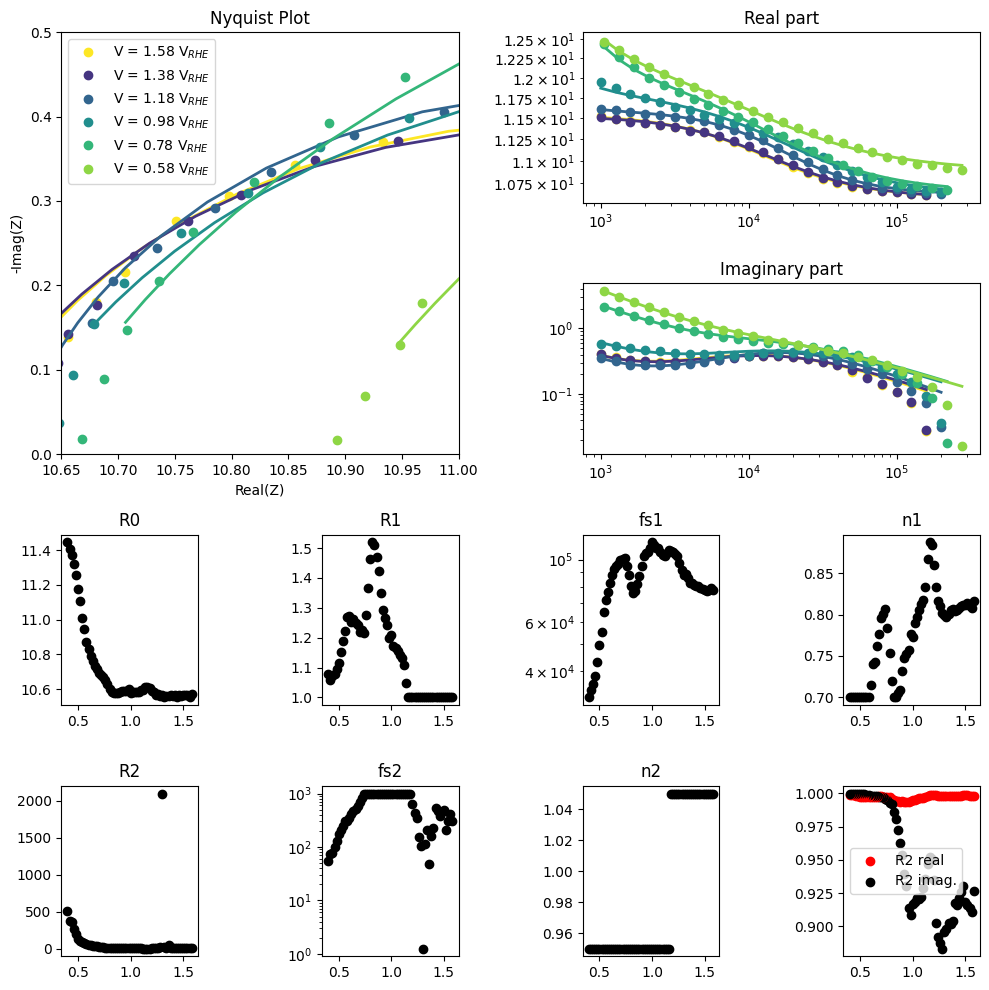

In [14]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(4, 4)

ax1 = fig.add_subplot(gs[:2, :2])
ax1.set_title('Nyquist Plot')

ax2 = fig.add_subplot(gs[0, 2:])
ax2.set_title('Real part')

ax3 = fig.add_subplot(gs[1, 2:])
ax3.set_title('Imaginary part')

axes = []
for i in range(4):
    for j in range(2, 4):
        ax = fig.add_subplot(gs[j, i])
        axes.append(ax)

from matplotlib.cm import viridis
colors = viridis(np.linspace(0, 1, len(mpr_files)))

Rs_guess = 10.66

R_guess = 1.37
n_guess = 0.8
fs_guess = 5.7e4

R2_guess = 65.8
n2_guess = 0.97
fs2_guess = 128.9

initial_guess = [Rs_guess, R_guess, fs_guess, n_guess, R2_guess, fs2_guess, n2_guess]

bounds = (
    [9., 1., 10**1, 0.7, 1, 10**0.1, 0.95],  # Lower bounds
    [12., 4., 10**7, 1.25, 1e8, 10**3, 1.05]  # Upper bounds

)

popt = []

fitted_values_HF_100cyc = dict()


for (n_file,file_path) in enumerate(mpr_files):
    mpr_file = BioLogic.MPRfile(file_path)
    df = pd.DataFrame(mpr_file.data)

    freq_min = 1000
    freq_max = 1e6
    filtered_df = df[(df['freq/Hz'] >= freq_min) & (df['freq/Hz'] <= freq_max) & (df['-Im(Z)/Ohm'] > 0)]

    Ewe = filtered_df["<Ewe>/V"].mean()

    frequencies = filtered_df['freq/Hz'].values
    real = filtered_df['Re(Z)/Ohm'].values
    imaginary = -filtered_df['-Im(Z)/Ohm'].values

    Z = np.concatenate((real, imaginary))
    omega = 2 * np.pi * frequencies

    try:
        if len(popt)>0:
            popt, pcov = curve_fit(rrcrc_cpe_model, omega, Z, p0=popt, bounds=bounds)
        else:
            popt, pcov = curve_fit(rrcrc_cpe_model, omega, Z, p0=initial_guess, bounds=bounds)

        R0_opt, R1_opt, fs1_opt, n1_opt, R2_opt, fs2_opt, n2_opt = popt

        fitted_values_HF_100cyc[file_path] = (Ewe,popt)
        #print(f'Ewe={Ewe:.2f} V, Optimal parameters: R0={R0_opt}, R1={R1_opt}, fs1={fs1_opt}, n1={n1_opt}, R2={R2_opt}, fs2={fs2_opt}, n2={n2_opt}')

        Z_fit = rrcrc_cpe_model(omega, *popt)
        real_fit = Z_fit[:len(frequencies)]
        imaginary_fit = Z_fit[len(frequencies):]

        if n_file%10 == 0:
            ax1.plot(real, -imaginary, 'o', color=colors[n_file-1], label=f"V = {Ewe:.2f} V$_{{RHE}}$")
            ax1.plot(real_fit, -imaginary_fit, '-', lw = 2,  color=colors[n_file-1])
            ax1.set_xlabel('Real(Z)')
            ax1.set_ylabel('-Imag(Z)')

            ax2.plot(frequencies, real, 'o', color=colors[n_file-1])
            ax2.plot(frequencies, real_fit, '-', lw=2, color=colors[n_file-1])
            
            ax3.plot(frequencies, -imaginary, 'o',color=colors[n_file-1])
            ax3.plot(frequencies, -imaginary_fit, '-', lw=2, color=colors[n_file-1])

        axes[0].scatter(Ewe, R0_opt, c = "k")
        axes[2].scatter(Ewe, R1_opt, c = "k")
        axes[4].scatter(Ewe, fs1_opt, c = "k")
        axes[6].scatter(Ewe, n1_opt, c = "k")
        axes[1].scatter(Ewe, R2_opt, c = "k")
        axes[3].scatter(Ewe, fs2_opt, c = "k")
        axes[5].scatter(Ewe, n2_opt, c = "k")

        def calculate_r_squared(observed, predicted):
            ss_res = np.sum((observed - predicted) ** 2)
            ss_tot = np.sum((observed - np.mean(observed)) ** 2)
            return 1 - (ss_res / ss_tot)

        r_squared_real = calculate_r_squared(real, real_fit)
        r_squared_imaginary = calculate_r_squared(imaginary, imaginary_fit)

        if n_file == 0:
            axes[7].scatter(Ewe, r_squared_real, c = "r", label = "R2 real")
            axes[7].scatter(Ewe, r_squared_imaginary, c = "k", label = "R2 imag.")
        else:
            axes[7].scatter(Ewe, r_squared_real, c = "r")
            axes[7].scatter(Ewe, r_squared_imaginary, c = "k")

    except RuntimeError:
        print(f"Ewe={Ewe:.2f} V - No fit")

axes[0].set_title("R0")
axes[2].set_title("R1")
axes[4].set_title("fs1")
axes[4].set_yscale("log")
axes[6].set_title("n1")
axes[1].set_title("R2")
axes[3].set_title("fs2")
axes[3].set_yscale("log")
axes[5].set_title("n2")

axes[7].legend()
ax1.legend()
ax1.set_xlim([10.65,11])
ax1.set_ylim([0,0.5])

ax2.set_xscale("log")
ax2.set_yscale("log")
ax3.set_xscale("log")
ax3.set_yscale("log")

plt.tight_layout()

## Fit whole range with HF values for first element

1.5804878 [1.05705695e+01 1.00000000e+00 7.78174775e+04 8.16725630e-01
 6.54372190e+00 3.09643759e+02 1.05000000e+00]
1.5804878 [1.05487015e+01 1.16683665e+00 5.50553830e+04 7.00000000e-01
 2.17982045e+01 4.20737148e+01 9.25794901e-01]
1.5604906 [1.05531024e+01 1.00000000e+00 7.90573865e+04 8.08402620e-01
 4.61957321e+00 4.19335235e+02 1.05000000e+00]
1.5604906 [1.05442611e+01 1.16788380e+00 5.24739363e+04 7.00000000e-01
 3.64048311e+01 2.28432050e+01 9.23440495e-01]
1.5404913 [1.05686908e+01 1.00000000e+00 7.76472375e+04 8.10467964e-01
 6.36066397e+00 3.03762092e+02 1.05000000e+00]
1.5404913 [1.05618582e+01 1.17322837e+00 5.02607934e+04 7.00000000e-01
 7.25284013e+01 1.05097869e+01 9.19987909e-01]
1.5205412 [1.05662217e+01 1.00000000e+00 7.75173619e+04 8.13696882e-01
 9.42629670e+00 2.10032990e+02 1.05000000e+00]
1.5205412 [1.05587765e+01 1.17626152e+00 4.99108092e+04 7.00000000e-01
 1.89519676e+02 3.69229073e+00 9.15066567e-01]


/tmp/ipykernel_18319/3329385170.py:66: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axes[0].errorbar(Ewe, popt_HF[0], yerr= [[popt_HF[0]*lim_R0], [popt_HF[0]*lim_R0]], fmt='o', ecolor='b', capsize=5, marker='o', markerfacecolor='b', markeredgecolor='b')
/tmp/ipykernel_18319/3329385170.py:67: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axes[2].errorbar(Ewe, popt_HF[1], yerr= [[popt_HF[1]*lim_R1], [popt_HF[1]*lim_R1]], fmt='o', ecolor='b', capsize=5, marker='o', markerfacecolor='b', markeredgecolor='b')
/tmp/ipykernel_18319/3329385170.py:68: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axes[4].errorbar(Ewe, popt_HF[2], yerr= [[popt_HF[2]*lim_fs1

1.5005108 [1.05693258e+01 1.00000000e+00 7.80193730e+04 8.11781331e-01
 4.03500887e+00 4.99281487e+02 1.05000000e+00]
1.5005108 [1.05824850e+01 1.20433321e+00 4.22849075e+04 7.00000000e-01
 5.40280980e+02 1.25892541e+00 9.21858607e-01]
1.4805233 [1.05625973e+01 1.00000000e+00 7.82761928e+04 8.11397304e-01
 4.61654825e+00 4.47000366e+02 1.05000000e+00]
1.4805233 [1.06121321e+01 1.25042702e+00 3.13513638e+04 7.00000000e-01
 5.96366326e+02 1.25892541e+00 9.37853681e-01]
1.4605204 [1.05689838e+01 1.00000000e+00 7.89915708e+04 8.10819846e-01
 5.69642982e+00 3.79793908e+02 1.05000000e+00]
1.4605204 [1.06259957e+01 1.25104368e+00 3.00479933e+04 7.00000000e-01
 6.17803316e+02 1.25892541e+00 9.40308354e-01]
1.4405602 [1.05544688e+01 1.00000000e+00 8.05370961e+04 8.08531029e-01
 4.39727210e+00 4.79129864e+02 1.05000000e+00]
1.4405602 [1.06057742e+01 1.24261438e+00 3.24936034e+04 7.00000000e-01
 6.38344430e+02 1.25892541e+00 9.42793516e-01]
1.4205309 [1.05653338e+01 1.00000000e+00 8.05884859e+04 

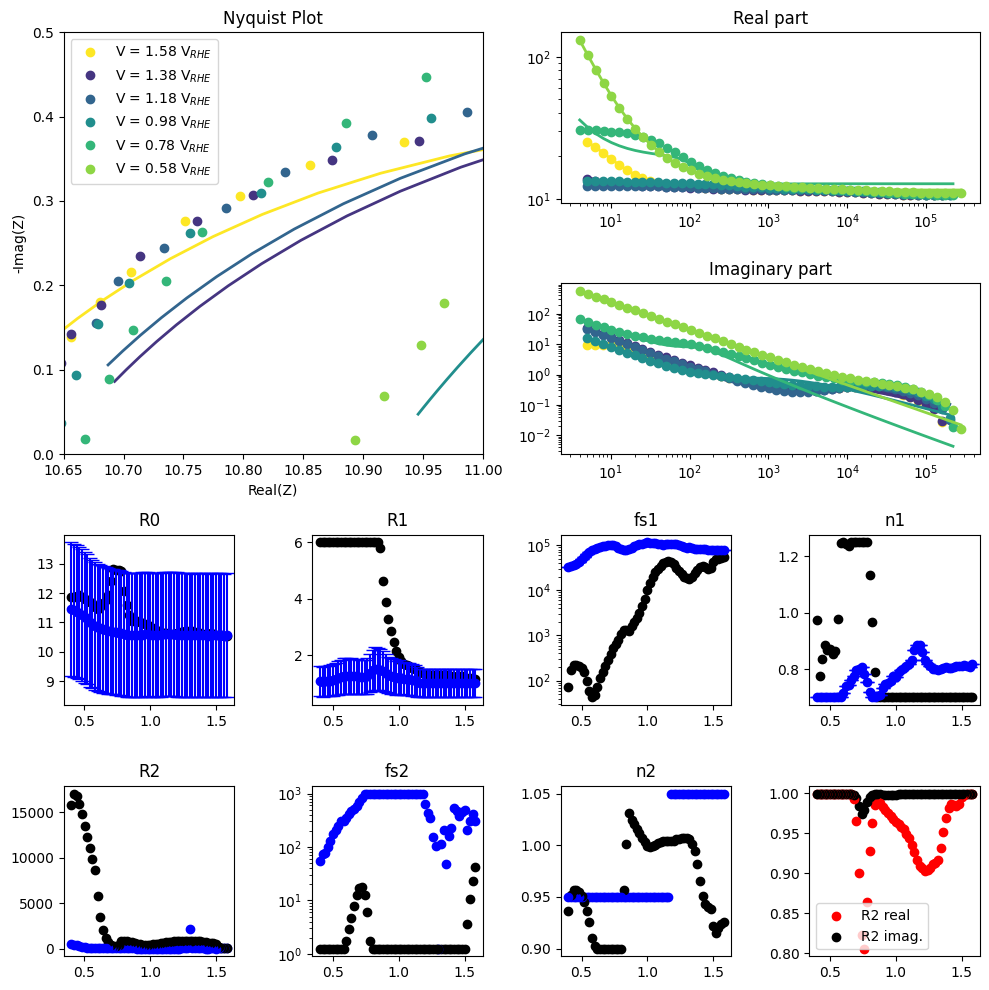

In [15]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(4, 4)

ax1 = fig.add_subplot(gs[:2, :2])
ax1.set_title('Nyquist Plot')

ax2 = fig.add_subplot(gs[0, 2:])
ax2.set_title('Real part')

ax3 = fig.add_subplot(gs[1, 2:])
ax3.set_title('Imaginary part')

axes = []
for i in range(4):
    for j in range(2, 4):
        ax = fig.add_subplot(gs[j, i])
        axes.append(ax)

from matplotlib.cm import viridis
colors = viridis(np.linspace(0, 1, len(mpr_files)))

# These values from the HR fit of 10 cyc 1.58 V
Rs_guess = 10.69

R_guess = 1.197
n_guess = 0.865
fs_guess = 7.045e4

# These values from first fit from Ben
R2_guess = 65.8
n2_guess = 0.97
fs2_guess = 128.9

initial_guess = [Rs_guess, R_guess, fs_guess, n_guess, R2_guess, fs2_guess, n2_guess]

popt = []

fitted_values_100cyc = dict()

for (n_file,file_path) in enumerate(mpr_files):
    mpr_file = BioLogic.MPRfile(file_path)
    df = pd.DataFrame(mpr_file.data)

    freq_min = 4
    freq_max = 1e6
    filtered_df = df[(df['freq/Hz'] >= freq_min) & (df['freq/Hz'] <= freq_max) & (df['-Im(Z)/Ohm'] > 0)]

    Ewe = filtered_df["<Ewe>/V"].mean()

    frequencies = filtered_df['freq/Hz'].values
    real = filtered_df['Re(Z)/Ohm'].values
    imaginary = -filtered_df['-Im(Z)/Ohm'].values

    Z = np.concatenate((real, imaginary))
    omega = 2 * np.pi * frequencies

    (Ewe_HF, popt_HF) = fitted_values_HF_100cyc[file_path]

    print (Ewe,popt_HF)

    lim_R0 = 0.2
    lim_R1 = 0.5
    lim_fs1 = 0.
    lim_n1 = 0.

    axes[0].errorbar(Ewe, popt_HF[0], yerr= [[popt_HF[0]*lim_R0], [popt_HF[0]*lim_R0]], fmt='o', ecolor='b', capsize=5, marker='o', markerfacecolor='b', markeredgecolor='b')
    axes[2].errorbar(Ewe, popt_HF[1], yerr= [[popt_HF[1]*lim_R1], [popt_HF[1]*lim_R1]], fmt='o', ecolor='b', capsize=5, marker='o', markerfacecolor='b', markeredgecolor='b')
    axes[4].errorbar(Ewe, popt_HF[2], yerr= [[popt_HF[2]*lim_fs1], [popt_HF[2]*lim_fs1]], fmt='o', ecolor='b', capsize=5, marker='o', markerfacecolor='b', markeredgecolor='b')
    axes[6].errorbar(Ewe, popt_HF[3], yerr= [[popt_HF[3]*lim_n1], [popt_HF[3]*lim_n1]], fmt='o', ecolor='b', capsize=5, marker='o', markerfacecolor='b', markeredgecolor='b')

    axes[1].scatter(Ewe, popt_HF[4], c = "b")
    axes[3].scatter(Ewe, popt_HF[5], c = "b")
    axes[5].scatter(Ewe, popt_HF[6], c = "b")

    ##################################### there is some problem here ###################################################
    #bounds = (
    #[(1-lim_R0)*popt_HF[0], (1-lim_R1)*popt_HF[1], 0.5*popt_HF[2], 0.75*popt_HF[3], 1, 10**0.1, 0.95],  # Lower bounds
    #[(1+lim_R0)*popt_HF[0], (1+lim_R1)*popt_HF[1], 1.5*popt_HF[2], 1.25*popt_HF[3], 1e8, 10**3, 1.05]  # Upper bounds
    #)

    #bounds = (
    #[(1-lim_R0)*popt_HF[0], (1-lim_R1)*popt_HF[1], (1-lim_fs1)*popt_HF[2], (1-lim_n1)*popt_HF[3], 1., 10**0.1, 0.9],  # Lower bounds
    #[(1+lim_R0)*popt_HF[0], (1+lim_R1)*popt_HF[1], (1+lim_fs1)*popt_HF[2], (1+lim_n1)*popt_HF[3], 1e8, 10**3, 1.05]  # Upper bounds
    #)

    #bounds = (
    #[(1-lim_R0)*popt_HF[0],1., 1e-1, 0.7, 1, 1e-1, 0.95],  # Lower bounds
    #[(1+lim_R0)*popt_HF[0], 20., 1e7, 1.25, 1e8, 1e3, 1.05]  # Upper bounds
    #)

    bounds = (
    [(1-lim_R0)*popt_HF[0], 1., 10**1, 0.7, 1, 10**0.1, 0.9],  # Lower bounds
    [(1+lim_R0)*popt_HF[0], 6., 10**7, 1.25, 1e8, 10**3, 1.05]  # Upper bounds
    )

    #######################################################################################

    try:
        if len(popt)>0:
            popt, pcov = curve_fit(rrcrc_cpe_model, omega, Z, p0=popt, bounds=bounds)
        else:
            popt, pcov = curve_fit(rrcrc_cpe_model, omega, Z, p0=initial_guess, bounds=bounds)

        R0_opt, R1_opt, fs1_opt, n1_opt, R2_opt, fs2_opt, n2_opt = popt

        fitted_values_100cyc[file_path] = (Ewe,popt)
        print (Ewe,popt)
        

        Z_fit = rrcrc_cpe_model(omega, *popt)
        real_fit = Z_fit[:len(frequencies)]
        imaginary_fit = Z_fit[len(frequencies):]

        if n_file%10 == 0:
            ax1.plot(real, -imaginary, 'o', color=colors[n_file-1], label=f"V = {Ewe:.2f} V$_{{RHE}}$")
            ax1.plot(real_fit, -imaginary_fit, '-', lw = 2,  color=colors[n_file-1])
            ax1.set_xlabel('Real(Z)')
            ax1.set_ylabel('-Imag(Z)')

            ax2.plot(frequencies, real, 'o', color=colors[n_file-1])
            ax2.plot(frequencies, real_fit, '-', lw=2, color=colors[n_file-1])
            
            ax3.plot(frequencies, -imaginary, 'o',color=colors[n_file-1])
            ax3.plot(frequencies, -imaginary_fit, '-', lw=2, color=colors[n_file-1])

        axes[0].scatter(Ewe, R0_opt, c = "k")
        axes[2].scatter(Ewe, R1_opt, c = "k")
        axes[4].scatter(Ewe, fs1_opt, c = "k")
        axes[6].scatter(Ewe, n1_opt, c = "k")
        axes[1].scatter(Ewe, R2_opt, c = "k")
        axes[3].scatter(Ewe, fs2_opt, c = "k")
        axes[5].scatter(Ewe, n2_opt, c = "k")


        def calculate_r_squared(observed, predicted):
            ss_res = np.sum((observed - predicted) ** 2)
            ss_tot = np.sum((observed - np.mean(observed)) ** 2)
            return 1 - (ss_res / ss_tot)

        r_squared_real = calculate_r_squared(real, real_fit)
        r_squared_imaginary = calculate_r_squared(imaginary, imaginary_fit)

        if n_file == 0:
            axes[7].scatter(Ewe, r_squared_real, c = "r", label = "R2 real")
            axes[7].scatter(Ewe, r_squared_imaginary, c = "k", label = "R2 imag.")
        else:
            axes[7].scatter(Ewe, r_squared_real, c = "r")
            axes[7].scatter(Ewe, r_squared_imaginary, c = "k")

    except RuntimeError:
        print(f"Ewe={Ewe:.2f} V - No fit")
    except ValueError:
        print(f"Ewe={Ewe:.2f} V - No fit")

axes[0].set_title("R0")
axes[2].set_title("R1")
axes[4].set_title("fs1")
axes[4].set_yscale("log")
axes[6].set_title("n1")
axes[1].set_title("R2")
axes[3].set_title("fs2")
axes[3].set_yscale("log")
axes[5].set_title("n2")

axes[7].legend()
ax1.legend()
ax1.set_xlim([10.65,11])
ax1.set_ylim([0,0.5])

ax2.set_xscale("log")
ax2.set_yscale("log")
ax3.set_xscale("log")
ax3.set_yscale("log")

plt.tight_layout()

# Plot all results

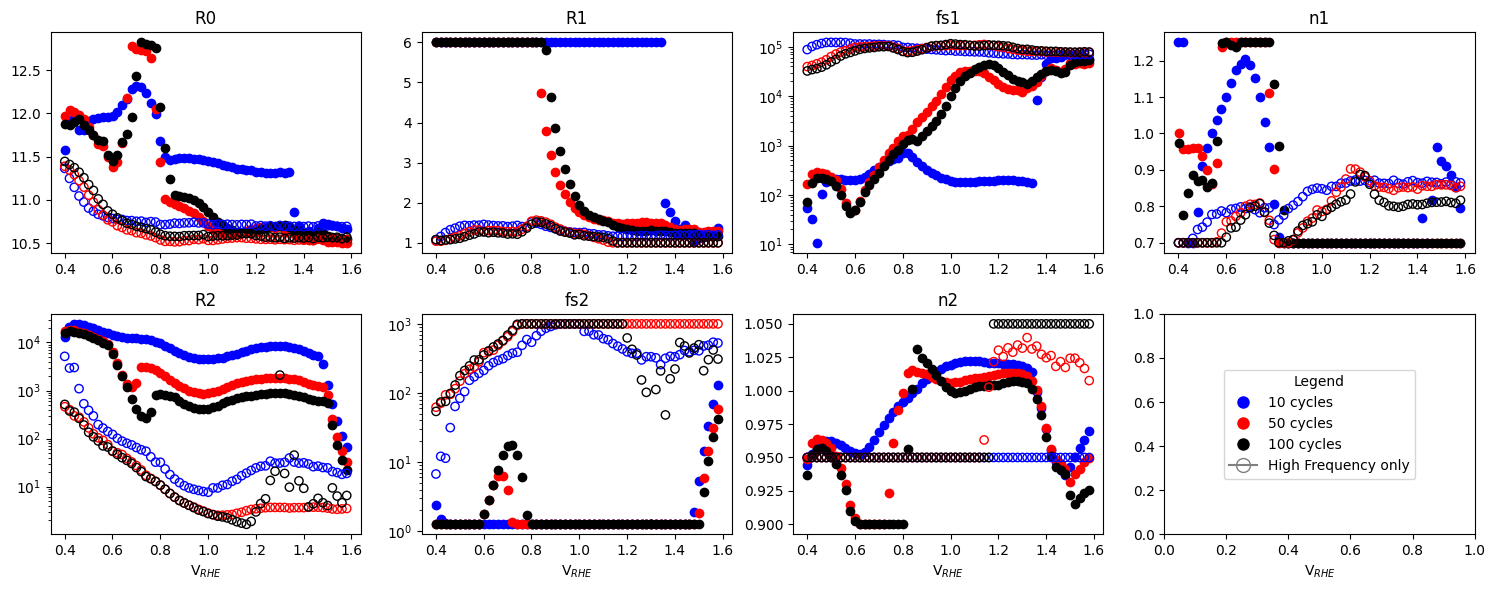

In [18]:
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, 4)

axes = []
for i in range(4):
    for j in range(0, 2):
        ax = fig.add_subplot(gs[j, i])
        axes.append(ax)
        if j==1:
            ax.set_xlabel("V$_{RHE}$")
axes[0].set_title("R0")
axes[2].set_title("R1")
axes[4].set_title("fs1")
axes[4].set_yscale("log")
axes[6].set_title("n1")
axes[1].set_title("R2")
axes[1].set_yscale("log")
axes[3].set_title("fs2")
axes[3].set_yscale("log")
axes[5].set_title("n2")

# legend
color_list = ["b","r","k",]

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_list[0], markersize=10, label='10 cycles'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_list[1], markersize=10, label='50 cycles'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_list[2], markersize=10, label='100 cycles'),
    Line2D([0], [0], marker='o', color='grey', markerfacecolor='none', markersize=10, label='High Frequency only')

]
axes[7].legend(handles=legend_elements, loc='center', title='Legend')

plt.tight_layout()


list_cycles = [fitted_values_10cyc,fitted_values_50cyc,fitted_values_100cyc]
list_cycles_HF = [fitted_values_HF_10cyc,fitted_values_HF_50cyc,fitted_values_HF_100cyc]
for (i,dict_cyc) in enumerate(list_cycles):
    for (j,key) in enumerate(dict_cyc):
        Ewe = dict_cyc[key][0]
        R0_opt, R1_opt, fs1_opt, n1_opt, R2_opt, fs2_opt, n2_opt = dict_cyc[key][1]

        axes[0].scatter(Ewe, R0_opt, c = color_list[i])
        axes[2].scatter(Ewe, R1_opt, c =  color_list[i])
        axes[4].scatter(Ewe, fs1_opt, c =  color_list[i])
        axes[6].scatter(Ewe, n1_opt, c =  color_list[i])
        axes[1].scatter(Ewe, R2_opt, c =  color_list[i])
        axes[3].scatter(Ewe, fs2_opt, c =  color_list[i])
        axes[5].scatter(Ewe, n2_opt, c =  color_list[i])

for (i,dict_cyc) in enumerate(list_cycles_HF):
    for (j,key) in enumerate(dict_cyc):
        Ewe = dict_cyc[key][0]
        R0_opt, R1_opt, fs1_opt, n1_opt, R2_opt, fs2_opt, n2_opt = dict_cyc[key][1]

        axes[0].scatter(Ewe, R0_opt, c = "none", edgecolor = color_list[i])
        axes[2].scatter(Ewe, R1_opt, c =  "none", edgecolor = color_list[i])
        axes[4].scatter(Ewe, fs1_opt, c =  "none", edgecolor = color_list[i])
        axes[6].scatter(Ewe, n1_opt, c =  "none", edgecolor = color_list[i])
        axes[1].scatter(Ewe, R2_opt, c =  "none", edgecolor = color_list[i])
        axes[3].scatter(Ewe, fs2_opt, c =  "none", edgecolor = color_list[i])
        axes[5].scatter(Ewe, n2_opt, c =  "none", edgecolor = color_list[i])


